In [1]:
# Imports necesarios
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# La fila 1 contiene el header
arr = np.loadtxt("tiempos.txt", skiprows=1)

soleado = arr[:,1]
nublado = arr[:,2]
lluvioso = arr[:,3]
my_labels = ['Soleado', 'Nublado', 'Lluvioso']


<hr>

# 1º - Plotear el dataset completo


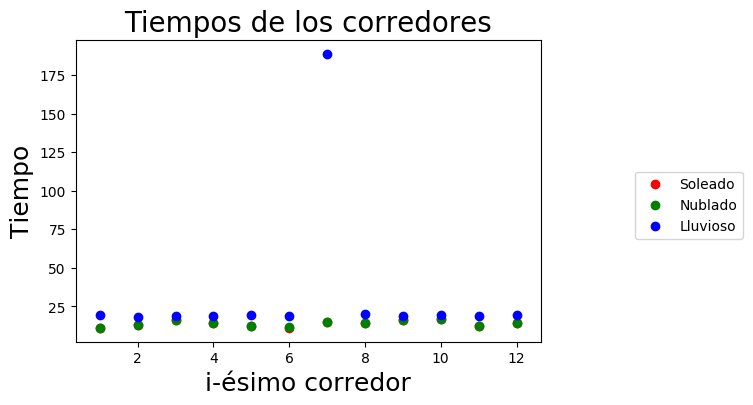

In [3]:
# PLOT SCATTER DE LOS DATOS
fig = plt.figure(dpi=100)
scat_soleado = plt.scatter(arr[:,0], soleado, color="r")
scat_nublado = plt.scatter(arr[:,0], nublado, color="g")
scat_lluvioso = plt.scatter(arr[:,0], lluvioso, color="b")

plt.axes().set_title('Tiempos de los corredores', fontsize=20)
plt.xlabel('i-ésimo corredor', fontsize=18)
plt.ylabel('Tiempo', fontsize=18)

# Cuadro de Leyendas
fig.legend((scat_soleado,scat_nublado,scat_lluvioso), my_labels, 'center right', bbox_to_anchor=(1.25, 0.5))

plt.show()

<blockquote>
    <h2>¿Con qué nos encontramos?</h2>
    <p>
        Todo parece indicar que el tiempo del 7mo corredor en clima Lluvioso es un <b>dato atípico</b>.
    </p>
</blockquote>

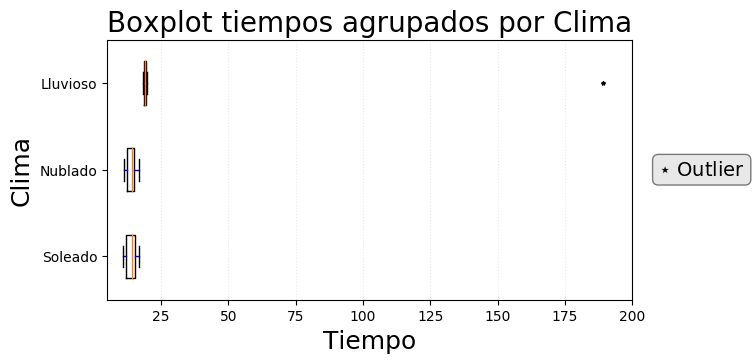

In [4]:
# BOXPLOT DE LOS DATOS POR CLIMA
data = [soleado, nublado, lluvioso]

fig = plt.figure(dpi=100)
ax1 = plt.axes()
fig.canvas.set_window_title('Boxplot tiempos agrupados por clima')
ax1.set_title('Boxplot tiempos agrupados por Clima', fontsize=20)
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

# Estilo del box
bp = plt.boxplot(data, vert=False, whis=1.5, labels=my_labels, widths=0.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='blue')
plt.setp(bp['fliers'], markersize=3, markerfacecolor='black',markeredgecolor='black', marker='*')

# Estilo de los ejes
ax1.xaxis.grid(True, linestyle=':', which='major', color='lightgrey', alpha=0.5)
ax1.set_axisbelow(True)
ax1.set_ylabel('Clima', fontsize=18)
ax1.set_xlabel('Tiempo', fontsize=18)
ax1.set_xlim(5, 200)

#Cuadro para señalizar los outliers
textstr = '$\star$ Outlier'
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
ax1.text(1.05, 0.5, textstr, transform=ax1.transAxes, fontsize=14,verticalalignment='center', bbox=props)

plt.show()

<blockquote>
    <h2>Descartamos al 7mo corredor</h2>
    <p>
        Dado que los datos son apareados, se decide por <i>descartar</i> al 7mo corredor.
    </p>
    <p>
        El set de datos sin este corredor queda de la siguiente forma.
    </p>
</blockquote>
<a id="plot_filtrado" ></a>

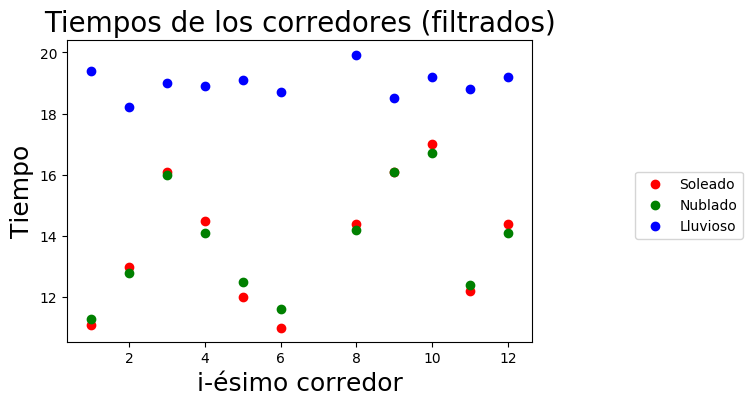

In [5]:
# Se descarta la información del 7mo corredor
arr = np.delete(arr, 6,0)
soleado = arr[:,1]
nublado = arr[:,2]
lluvioso = arr[:,3]
data = [soleado, nublado, lluvioso]

#Ploteamos de nuevo
fig = plt.figure(dpi=100)
scat_soleado = plt.scatter(arr[:,0], soleado, color="r")
scat_nublado = plt.scatter(arr[:,0], nublado, color="g")
scat_lluvioso = plt.scatter(arr[:,0], lluvioso, color="b")

plt.axes().set_title('Tiempos de los corredores (filtrados)', fontsize=20)
plt.xlabel('i-ésimo corredor', fontsize=18)
plt.ylabel('Tiempo', fontsize=18)

fig.legend((scat_soleado,scat_nublado,scat_lluvioso), my_labels, 'center right', bbox_to_anchor=(1.25, 0.5))

plt.show()

<hr>
# 2º Antes de aplicar test sobre nuestros datos

<blockquote>
    <h2>Test de Normalidad (Shapiro - Wil)</h2>
    <p>
        Considerando los tiempos de cada clima como una variable aleatoria, quisieramos saber si pueden provenir de una distribución Normal.
    </p>
    <p>
        <b>Hipótesis Nula:</b> Los datos provienen de una distribución Normal.
        <br> <b>&alpha;-level:</b> 0.05
    </p>
</blockquote>

In [6]:
# Usamos stats
_, norm_p1 = stats.shapiro(soleado)
_, norm_p2 = stats.shapiro(nublado)
_, norm_p3 = stats.shapiro(lluvioso)

for i in range(0,3):
    _, test_p_value = stats.shapiro(data[i])
    print ("Shapiro test de la V.A. '{}' p-value: {},".format(my_labels[i],test_p_value))
    

Shapiro test de la V.A. 'Soleado' p-value: 0.42219114303588867,
Shapiro test de la V.A. 'Nublado' p-value: 0.3774447739124298,
Shapiro test de la V.A. 'Lluvioso' p-value: 0.9883151650428772,


<blockquote>
    <h2>Resultados</h2>
    <p>
        No se rechaza la <b>hipótesis nula</b> sobre ninguna variable aleatoria. Asumiremos que las variables tienen distribución normal.
    </p>
</blockquote>

<blockquote>
    <h2>Test de misma Varianza (Levene)</h2>
    <p>
        Queremos ver si nuestras VAs presentan misma varianza, agrupando las 3 y agrupando de a 2.
        <br> Elegimos un test de Levene dado que es menos sensibles a distribuciones no normales.
    </p>
    <p>
        <b>Hipótesis Nula:</b> Las VAs en cuestión presentan misma varianza
        <br> <b>&alpha;-level:</b> 0.05
    </p>
</blockquote>

In [7]:
# Usamos el método levene de stats

_, p_value_all = stats.levene(soleado, nublado, lluvioso)
print("Levene test p-value de las tres: {}".format(p_value_all))

# Comparación tomando de a 2

for i in range(0,len(data)):
    for j in range(i+1,len(data)):
        _, p_value = stats.levene(data[i], data[j])
        print("Levene test p-value para VAs '{}' y '{}': {}".format(my_labels[i],my_labels[j],p_value))


Levene test p-value de las tres: 0.004061494634406996
Levene test p-value para VAs 'Soleado' y 'Nublado': 0.6734363390373725
Levene test p-value para VAs 'Soleado' y 'Lluvioso': 0.001922547526531154
Levene test p-value para VAs 'Nublado' y 'Lluvioso': 0.0019301380767628243


<blockquote>
    <h2>Resultados</h2>
    <p>
        Se rechaza la <b>hipótesis nula</b> entre la VA 'Lluvioso' y cualquier otra, así como las tres juntas. 
        Entre días soleados y nublados no se rechaza la hipótesis.
    </p>
    <p>
        Esto nos permite:
        <ul>
          <li>Utilizar t-test para comparaciones sobre las VAs 'Soleado' y 'Nublado'.</li>
          <li>Utilizar Welch t-test para comparaciones de alguna VA con 'Lluvioso'.</li>
          <li>Para todos los casos se puede utilizar test no-paramétricos.</li>
        </ul>
    </p>
</blockquote>

<hr>
# Respuestas a los items propuestos

<a id="item1"></a>
<blockquote>
    <h2>Item 1 - "Los atletas son más lentos en dı́as de lluvia que en dı́as soleados."</h2>
    <p>
        Trataremos de negar lo opuesto. Aunque hay información suficiente para rechazar que ambas VA tengan misma varianza, no podemos negar que ambas variables provengan de una distribución normal, por lo que utilizaremos un Welch t-test.
    </p>
    <p>
        <b>Hipótesis nula:</b> Los atletas tienen mayor o igual velocidad en los dias lluviosos que en dias soleados.
        <br> <b>&alpha;-level:</b> 0.05
    </p>
</blockquote>

In [8]:
# Usamos Welch t-test de stats

for i in range(0,len(data)):
    for j in range(i+1,len(data)):
        _, p_value = stats.ttest_ind(data[i], data[j], equal_var=False)
        print("Welch's test p-value para VAs '{}' y '{}': {}".format(my_labels[i],my_labels[j],p_value/2))
        
# Para convertir este test de dos colas en una sola, basta por dividir por dos.
# Esto se verifica viendo el código de la funcion para obtener el p-value https://github.com/scipy/scipy/blob/v0.14.0/scipy/stats/stats.py#L3105-L3111

Welch's test p-value para VAs 'Soleado' y 'Nublado': 0.5
Welch's test p-value para VAs 'Soleado' y 'Lluvioso': 3.1404779336801015e-06
Welch's test p-value para VAs 'Nublado' y 'Lluvioso': 9.323251731263422e-07


<blockquote>
    <h2>Item 1 - Resultados</h2>
    <p>
        Hay información suficiente para rechazar la <b>hipótesis nula</b> en los casos que compara a la variable 'Lluvioso'.
        <br> Se concluye que los atletas son más lentos en días de lluvia.
    </p>
</blockquote>

<blockquote>
    <h3>Item 1 (bis) - Probando con un test no-parámetrico</h3>
    <p>
        Trataremos nuevamente negar lo opuesto pero esta vez utilizando un test de permutación.
    </p>
    <p>
        <b>Hipótesis nula:</b> Los atletas tienen igual o mayor velocidad en los dias lluviosos que en dias soleados.
        <br> <b>&alpha;-level:</b> 0.05
    </p>
</blockquote>

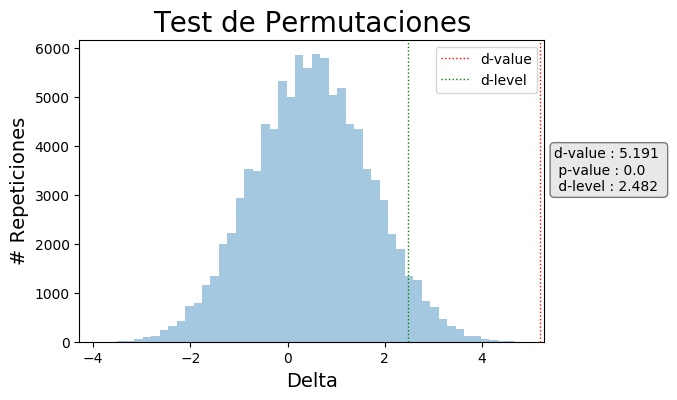

In [9]:
def calcular_delta(d,e):
    mean_1_inicial = d[e == e[0]].mean()
    mean_2_inicial = d[e != e[0]].mean()
    return mean_2_inicial - mean_1_inicial


def permutation_test(d,e, n=100000):
    d0 = calcular_delta(d, e)
    deltas = np.zeros(n)
    aux_e = e.copy()

    for i in range(n):
        np.random.shuffle(aux_e)
        deltas[i] = calcular_delta(d,aux_e)

    return deltas, d0

def foo(a, e_a, b, e_b):
    e_1 = np.full(a.shape[0], e_a) 
    e_2 = np.full(b.shape[0], e_b)
    e = np.concatenate((e_1, e_2)) 
    d = np.concatenate((a,b))
    return d,e

d, e = foo(soleado, 's', lluvioso, 'l')

# delta-value : la diferencia entre las medias que presenta nuestra información 
# p-value es la probabilidad de haber obtenido este delta o mayor

deltas, delta_value = permutation_test(d,e)
p_value =  deltas[deltas >= delta_value].shape[0]/deltas.shape[0]

#print("Delta-value = {} | p-value = {}".format(delta_value, p_value))

# Delta-level : el delta que atrapa el percentil 1-'alpha-level' de la distribución
# Nuestro Delta-value debería caer antes de a esto para no rechazar H0
delta_level = np.percentile(deltas, 95)

fig = plt.figure(dpi=100)
plt.axes().set_title('Test de Permutaciones', fontsize=20)
plt.axes().set_xlabel('Delta', fontsize=14) 
plt.axes().set_ylabel('# Repeticiones', fontsize=14) 

sns.distplot(deltas, norm_hist=False, kde=False)
plt.axvline(x=delta_value, linewidth=1, color='red', linestyle="dotted", label="d-value")
plt.axvline(x=delta_level, linewidth=1, color='g', linestyle="dotted", label="d-level")

plt.legend()

#Cuadro para printear valores
textstr = "d-value : {} \n p-value : {} \n d-level : {}".format(round(delta_value,3),round(p_value,3),round(delta_level,3))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
plt.axes().text(0.97, 0.5, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='center', bbox=props)

plt.show()

<blockquote>
    <h3>Item 1 (bis) - Resultados</h3>
    <p>
        Hay información suficiente para rechazar la <b>hipótesis nula</b>.
        <br> Se concluye al igual que antes, que los tiempos en los días lluviosos son mayores que en los tiempos soleados. 
    </p>
</blockquote>

<blockquote>
    <h2>Item 2 - "El cielo nublado no influye en los tiempos de los atletas."</h2>
    <p>
        No hay información suficiente para rechazar que tengan misma varianza o que los datos provengan de una distribución normal. Asumiremos que esto vale y utilizaremos un t-test para tratar de rechazar que sus medias sean iguales, es decir, rechazar que no influye. En este caso aprovechando la forma de los datos, utilizamos un <b>t-test apareado</b>.
    </p>
    <p>
        <b>Hipótesis nula:</b> La media de tiempos es igual tanto si esta nublado como soleado.
        <br> <b>&alpha;-level:</b> 0.05
    </p>
</blockquote>

In [10]:
# t-test apareado
_, pvalue = stats.ttest_rel(soleado, nublado)
print("t-test apareado entre las VAs'soleado' y 'nublado' a dos colas: {}".format(pvalue))
# No se puede rechazar la igualdad de medias, no se llega a ninguna conclusion 

t-test apareado entre las VAs'soleado' y 'nublado' a dos colas: 0.9999999999999988


<blockquote>
    <h2>Item 2 - Resultados</h2>
    <p>
        No hay información suficiente para rechazar la <b>hipótesis nula</b>.
        <br> Por lo que no se puede rechazar que "el cielo nublado no influye", ploteando los datos y conociendo el dominio uno puede llegar a la idea intuitiva de que efectivamente no influye.
    </p>
</blockquote>

<blockquote>
    <h2>Item 3 - "La velocidad en dı́as de lluvia es independiente del atleta."</h2>
    <p>
        Si la velocidad o los tiempos fueran dependientes del atleta se puede esperar que la performance de los mismos mantenga la misma o similar relación de orden. De ser esto cierto, debería encontrarse correlación entre todos los tiempos (más que nada respecto a la lluvia).
    </p>
</blockquote>

<blockquote>
    <h4>¿Hay correlación entre los días soleados y nublados?</h4>
    <p>
        <b>Hipótesis nula:</b> las variables aleatorias no estan correalacionadas.
        <br> <b>&alpha;-level:</b> 0.05
    </p>
</blockquote>

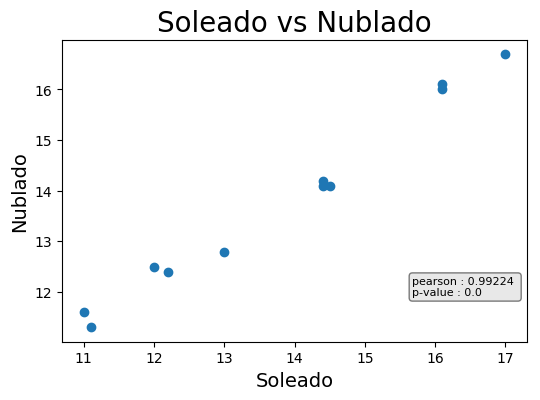

In [11]:
fig = plt.figure(dpi=100)
plt.axes().set_title('Soleado vs Nublado', fontsize=20)
plt.axes().set_xlabel('Soleado', fontsize=14) 
plt.axes().set_ylabel('Nublado', fontsize=14) 
plt.scatter(soleado,nublado)

pearson, p_value = stats.pearsonr(soleado,nublado)

#Cuadro para printear valores
textstr = "pearson : {} \np-value : {} ".format(round(pearson,5),round(p_value,5))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
plt.axes().text(0.7, 0.05, textstr, transform=ax1.transAxes, fontsize=8,verticalalignment='center', bbox=props)

plt.show()

<blockquote>
    <p>
        Se rechaza la Hipótesis Nula, los resultados sugieren una correlación en la velocidad de los atletas entre los días soleados y nublados.
    </p>
</blockquote>

<blockquote>
    <h4>¿Hay correlación entre los días soleados y lluviosos?</h4>
    <p>
        <b>Hipótesis nula:</b> las variables aleatorias no estan correalacionadas.
        <br> <b>&alpha;-level:</b> 0.05
    </p>
</blockquote>

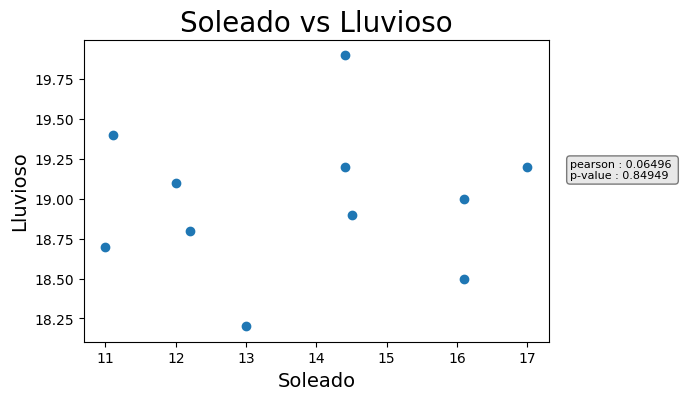

In [12]:
fig = plt.figure(dpi=100)
plt.axes().set_title('Soleado vs Lluvioso', fontsize=20)
plt.axes().set_xlabel('Soleado', fontsize=14) 
plt.axes().set_ylabel('Lluvioso', fontsize=14) 
plt.scatter(soleado,lluvioso)

pearson, p_value = stats.pearsonr(soleado,lluvioso)

#Cuadro para printear valores
textstr = "pearson : {} \np-value : {}".format(round(pearson,5),round(p_value,5))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
plt.axes().text(1.0, 0.5, textstr, transform=ax1.transAxes, fontsize=8,verticalalignment='center', bbox=props)


plt.show()

<blockquote>
    <p>
        No se puede rechazar la Hipótesis Nula. Los datos sugieren que no hay correlación entre los tiempos obtenidos un día de lluvia y un día soleado.
    </p>
</blockquote>

<blockquote>
    <h2>Item 3 - Resultados</h2>
    <p> No se pudo demostrar dependencia, lo cual suma un punto a favor de la "independencia".
    Viendo el gráfico de [tiempos completos](#plot_filtrado), parece intuitiva la no correlacion y la independencia de variables pero no se puede demostrar.
    </p>
</blockquote>

<blockquote>
    <h2>Item 4 - "El clima influye en la velocidad de los atletas." </h2>
    <p>
        Además de las conclusiones anteriores, los experimentos realizados nos permiten concluir que los días lluviosos difieren del resto en: 
        <ul>
            <li> media
            <li> varianza
        </ul>
        <br> Se puede concluir entonces que el clima influye en la velocidad de los atletas.
        En particular como se vió en el [Item 1](#item1) se obtiene un rendimiento peor que en los días habituales.
    </p>
</blockquote>

<blockquote>
    <h2>Item 5 - "Consejo al entrenador" </h2>
    <p>
        La correlación entre los tiempos de los días nublados y soleados permite inferir que mejorar en uno de los días nos permite mejorar en el otro.
        <br> Por otro lado, no parece haber una dependencia de estos con el rendimiento de los atletas en los días lluviosos.
        No se puede deducir entonces que mejorar los tiempos en un día lluvioso implique una mejora en otro clima. Por lo tanto, no parece ser de utilidad entrenar al aire libre en los días lluviosos.
        <br> Para dirimir esta problemática, se sugiere al entrenador considerar entrenar los días lluviosos en algún lugar techado. De ser esto imposible, se puede considerar predicciones climáticas y mover la fecha de entremamiento de manera acorde.
    </p>
    <br>
</blockquote>